# Restaurant Dataset - Deep Learning Model (BiLSTM) with Elmo pre-trained embeddings

Importing necessary modules

In [ ]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split

In [1]:
!pip install seqeval

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 24.8 MB 11.9 MB/s eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=95ccb1d003b32c63db2cc96a1d6c22d9aa91c66b256a25940ba4f0cd6f56debe
  Stored in directory: /home/lujun/.cache/pip/wheels/71/b4/9b/3caba6a5308e31516acd63e3a07c5887cec85f1f9d909d3d59
Successfully built seqeval


Here, I initialize the tensorflow session and import Elmo pre-trainied embeddings

In [ ]:
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

**Preprocessing the data file to make the required dataframe**

In [ ]:
def ret_df_file(file):
    with open(file, "r") as f:
        lines = f.readlines()
        size = len(lines) 
        idx_list = [idx + 1 for idx, val in
                enumerate(lines) if val == '\n'] 
        res = [lines[i: j-1] for i, j in
            zip([0] + idx_list, idx_list + 
            ([size] if idx_list[-1] != size else []))] 
        queries = ['' for i in range(len(res))]
        tags = []
        unigrams = []
        for i, ele in enumerate(res):
            for j, actual_str in enumerate(ele):
                res[i][j] = actual_str.split('\t')
                res[i][j][-1] = res[i][j][-1].replace('\n', '')
                tags.append(res[i][j][0])
                if j!=0:
                    queries[i] = queries[i] + ' ' + res[i][j][-1]
                else:
                    queries[i] = res[i][j][-1]
                unigrams.append(res[i][j][-1])
    df_queries = []
    pos = []
    for i, ele in enumerate(res):
        for j, actual_str in enumerate(ele):
            df_queries.append("Sentence: "+str(i))
            pos.append(j)
    return pd.DataFrame({"Word": unigrams, "Tag": tags, "Query": df_queries})

In [ ]:
df_train = ret_df_file("restauranttrain.bio")
df_test = ret_df_file("restauranttest.bio")

In [ ]:
df_train.head()

,Word,Tag,Query
0,2,B-Rating,Sentence: 0
1,start,I-Rating,Sentence: 0
2,restaurants,O,Sentence: 0
3,with,O,Sentence: 0
4,inside,B-Amenity,Sentence: 0


In [ ]:
words = set(list(df_train['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

3805

In [ ]:
tags = list(set(df_train["Tag"].values))
n_tags = len(tags)
n_tags

17

**Function for getting each query and making a batch for training**

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Query").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(df_train)
sent = getter.get_next()
print(sent)

[('34', 'O')]


In [ ]:
sentences = getter.sentences
print(len(sentences))

7660


In [ ]:

largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 35 words


**Looking at the frequency of the number of words in the queries**

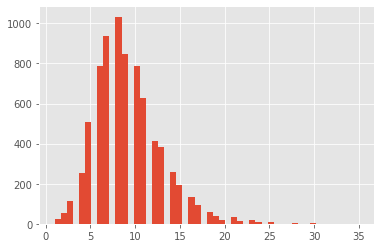

In [ ]:

plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [ ]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['my'])
print(tags2index['B-Location'])

2228
11


In [ ]:
max_len = 15
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['could',
 'you',
 'find',
 'me',
 'a',
 'high',
 'end',
 'halal',
 'restaurant',
 'open',
 'until',
 '12',
 'pm',
 'PADword',
 'PADword']

**Padding all the sequences to a length of 15** 

In [ ]:
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 3,  3,  3,  3,  3,  3,  3,  1,  3, 16,  0,  0,  0,  3,  3],
      dtype=int32)

**Spliting the data in train and test**

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

**Defining the structure of the Elmo embedding**

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

**Defining the model architecture with BiLSTMs**

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
X_tr, X_val = X_tr[:190*batch_size], X_tr[-25*batch_size:]
y_tr, y_val = y_tr[:190*batch_size], y_tr[-25*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

**Training the model**

In [ ]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 6080 samples, validate on 800 samples
Epoch 1/3
6080/6080 [==============================] - 970s 160ms/step - loss: 0.4223 - acc: 0.8827 - val_loss: 0.2803 - val_acc: 0.9147
Epoch 2/3
6080/6080 [==============================] - 955s 157ms/step - loss: 0.2461 - acc: 0.9261 - val_loss: 0.2646 - val_acc: 0.9213
Epoch 3/3
6080/6080 [==============================] - 953s 157ms/step - loss: 0.1992 - acc: 0.9379 - val_loss: 0.2620 - val_acc: 0.9227


**Checking the performance of the model on the test set**

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:23*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

736/736 [==============================] - 73s 99ms/step


In [ ]:

idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:23*32])

**Looking at the classification report for the model predictions on the test set**

In [ ]:

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 69.2%
                 precision    recall  f1-score   support

        Cuisine       0.82      0.78      0.80       304
       Location       0.73      0.74      0.74       376
        Amenity       0.57      0.41      0.47       256
           Dish       0.60      0.66      0.63       133
         Rating       0.67      0.73      0.70       101
          Hours       0.61      0.57      0.59        90
Restaurant_Name       0.77      0.77      0.77       177
          Price       0.80      0.70      0.75        64

      micro avg       0.71      0.68      0.69      1501
      macro avg       0.71      0.68      0.69      1501



In [1]:
print("Micro-precision is ",(0.82+0.73+0.57+0.67+0.61+0.8)/6)

Micro-precision is  0.6999999999999998
